## Introduction

In this project the main goal is to create a proof of concept (POC) product for providing a risk evaluation service for retail banks. This POC would be based on machine learning models that were trained on [HOME CREDIT DEFAULT RISK](https://storage.googleapis.com/341-home-credit-default/home-credit-default-risk.zip) dataset. Our idea is to have two different models which will be predicting the loan default risk for two types of loans: credit and revolving. This could be a good way for a bank to minimize loses of defaulted loans. To evaluate the models performance we will calculate the expected losses and profits for each model and the decide if they are useful and save money for the bank or not. The goal when training the models is to to minimize the false negative predictions by the classifier. If a client that is actually a loan defaulter gets misclassified as a non-defaulter by the classifier, then this model will not be able to accurately prevent loan default and consequently the bank will incur huge losses. Therefore, there is a need for a model that is robust to these pitfalls.

## Contents

* [Necessary libraries](#1)
* [Entity relationship diagram](#2)
* [Application train/test datasets](#3)
* [Bureau dataset](#4)
* [Bureau balance dataset](#5)
* [Previous application dataset](#6)
* [Pos cash balance dataset](#7)
* [Installment payments dataset](#8)
* [Credit card balance dataset](#9)
* [Aggregations](#10)
* [Avoiding data leakage](#11)
* [Cleaning up the feature names](#12)
* [Splitting data into Cash and Revolving loans](#13)
* [Dealing with missing values](#14)
* [Exporting data for further use](#15)


## Reference to other notebooks
* [Exploratory Data Analysis](./3%20EDA.ipynb)
* [Cash loan default classification model](./4%20Cash%20loan%20default%20classification.ipynb)
* [Revolving loan default classification model](./5%20Revolving%20loan%20default%20classification.ipynb)

## Necessary libraries <a id="1"></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from wand.image import Image as WImage
import pandas as pd
pd.set_option("display.max_columns", None)
import cleaningtools as ct
import numpy as np
import featuretools as ft

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

## Entity relationship diagram <a id="2"></a>

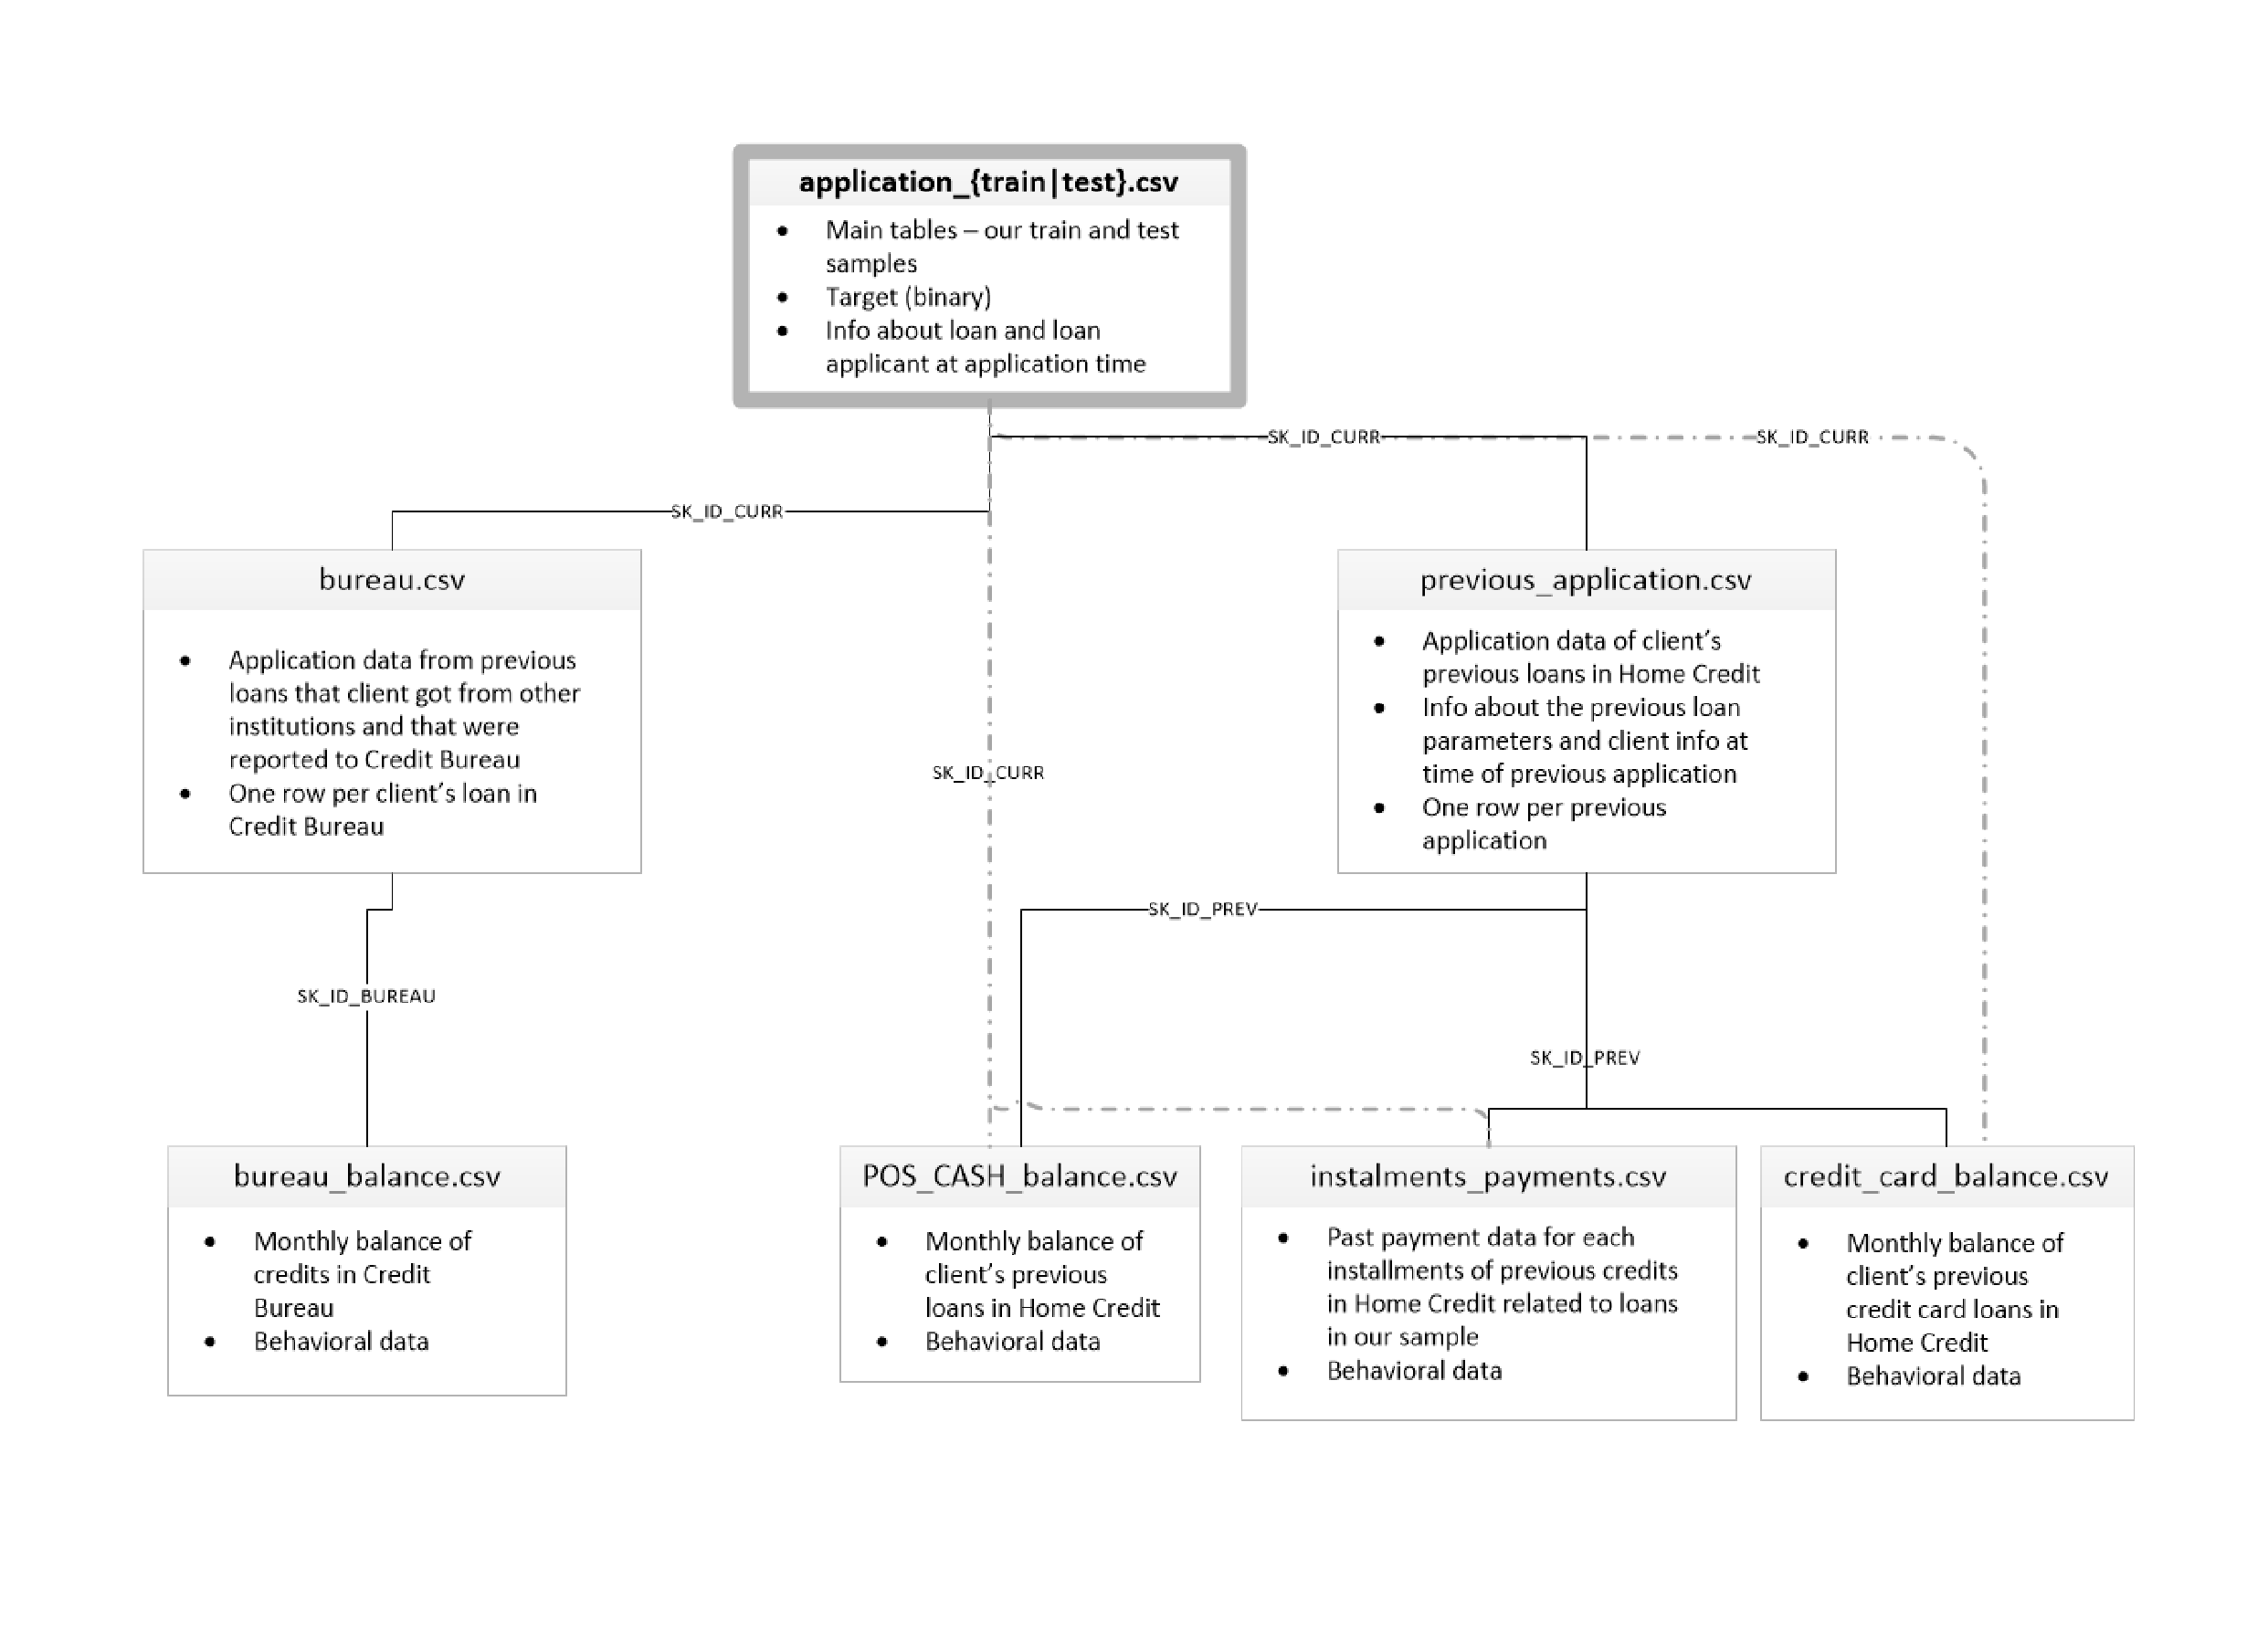

In [3]:
img = WImage(filename="../assets/Home Credit Default Risk.pdf[1]", resolution=300)
img[0:2483, 0:1800]

## application_train/application_test <a id="3"></a>

This is main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 1: loan defaulted and 0: other cases.

In [4]:
application_train = pd.read_csv("../data/application_train.csv")
application_test = pd.read_csv("../data/application_test.csv")
application_train = ct.convert_types(application_train, print_info=True)
application_test = ct.convert_types(application_test, print_info=True)
ct.overview_data(application_train, display_frst_value=True)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.1 gb.
Original Memory Usage: 0.05 gb.
New Memory Usage: 0.02 gb.
The DataFrame has 307511 rows and 122 columns.
+-----+------------------------------+-------------+------+-------------+----------+---------------+
|     | Column                       |   NA Values |    % | Data Type   |   Unique | First Value   |
|-----+------------------------------+-------------+------+-------------+----------+---------------|
|   0 | SK_ID_CURR                   |           0 |  0   | int32       |   307511 | 100002        |
|   1 | TARGET                       |           0 |  0   | category    |        2 | 1             |
|   2 | NAME_CONTRACT_TYPE           |           0 |  0   | category    |        2 | Cash loans    |
|   3 | CODE_GENDER                  |           0 |  0   | category    |        3 | M             |
|   4 | FLAG_OWN_CAR                 |           0 |  0   | category    |        2 | N             |
|   5 | FLAG_OWN_REALTY      

In [5]:
application_train['CODE_GENDER'].replace('XNA',np.nan, inplace=True)
application_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
application_train["ORGANIZATION_TYPE"].replace("XNA", np.nan, inplace=True)
application_train["NAME_FAMILY_STATUS"].replace("Unknown", np.nan, inplace=True)

selected_col = [
    "CNT_FAM_MEMBERS",
    "CNT_CHILDREN",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
]
for col in selected_col:
    application_train[col] = application_train[col].astype("Int32")
    application_train[col] = application_train[col].astype("category")

application_train = ct.clean_column_names(application_train)

In [6]:
"TARGET" in application_test.columns

False

The `TARGET` feature in the test set is missing. So this dataset won't be used in this project.

## bureau <a id="4"></a>

This data concerns client's earlier credits from other financial institutions. Some of the credits may be active and some are closed. Each previous (or ongoing) credit has its own row (only one row per credit) in *bureau* dataset. As a single client might have taken other loans from other financial institutions, for each row in the *application_train* data we can have multiple rows in this table.

In [7]:
bureau = pd.read_csv("../data/bureau.csv")
bureau = ct.convert_types(bureau, print_info=True)
ct.overview_data(bureau, display_frst_value=True)
bureau = ct.clean_column_names(bureau)

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.1 gb.
The DataFrame has 1716428 rows and 17 columns.
+----+------------------------+-------------+------+-------------+----------+---------------+
|    | Column                 |   NA Values |    % | Data Type   |   Unique | First Value   |
|----+------------------------+-------------+------+-------------+----------+---------------|
|  0 | SK_ID_CURR             |           0 |  0   | int32       |   305811 | 215354        |
|  1 | SK_ID_BUREAU           |           0 |  0   | int32       |  1716428 | 5714462       |
|  2 | CREDIT_ACTIVE          |           0 |  0   | category    |        4 | Closed        |
|  3 | CREDIT_CURRENCY        |           0 |  0   | category    |        4 | currency 1    |
|  4 | DAYS_CREDIT            |           0 |  0   | int32       |     2923 | -497          |
|  5 | CREDIT_DAY_OVERDUE     |           0 |  0   | int32       |      942 | 0             |
|  6 | DAYS_CREDIT_ENDDATE    |      105553 |  6.

## bureau_balance <a id="5"></a>

It is monthly data about the remaining balance of each one of the previous credits of clients that exist in dataset bureau. Each previous credit is identified by a unique ID, SK_ID_BUREAU, in dataset bureau. Each row in bureau_balance is one month of credit-due (from previous credit), and a single previous credit can have multiple rows, one for each month of the credit length.

In [8]:
bureau_balance = pd.read_csv("../data/bureau_balance.csv")
bureau_balance = ct.convert_types(bureau_balance, print_info=True)
ct.overview_data(bureau_balance, display_frst_value=True)
bureau_balance = ct.clean_column_names(bureau_balance)

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.25 gb.
The DataFrame has 27299925 rows and 3 columns.
+----+----------------+-------------+-----+-------------+----------+---------------+
|    | Column         |   NA Values |   % | Data Type   |   Unique | First Value   |
|----+----------------+-------------+-----+-------------+----------+---------------|
|  0 | SK_ID_BUREAU   |           0 |   0 | int32       |   817395 | 5715448       |
|  1 | MONTHS_BALANCE |           0 |   0 | int32       |       97 | 0             |
|  2 | STATUS         |           0 |   0 | category    |        8 | C             |
+----+----------------+-------------+-----+-------------+----------+---------------+


## previous_application <a id="6"></a>

This dataset has details of previous applications made by clients to Home Credit. Only those clients find place here who also exist in application data. Each current loan in the application data (identified by SK_ID_CURR) can have multiple previous loan applications. Each previous application has one row and is identified by the feature SK_ID_PREV.

In [9]:
previous_application = pd.read_csv("../data/previous_application.csv")
previous_application = ct.convert_types(previous_application, print_info=True)
ct.overview_data(previous_application, display_frst_value=True)

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.
The DataFrame has 1670214 rows and 37 columns.
+----+-----------------------------+-------------+------+-------------+----------+---------------+
|    | Column                      |   NA Values |    % | Data Type   |   Unique | First Value   |
|----+-----------------------------+-------------+------+-------------+----------+---------------|
|  0 | SK_ID_PREV                  |           0 |  0   | int32       |  1670214 | 2030495       |
|  1 | SK_ID_CURR                  |           0 |  0   | int32       |   338857 | 271877        |
|  2 | NAME_CONTRACT_TYPE          |           0 |  0   | category    |        4 | Consumer l... |
|  3 | AMT_ANNUITY                 |      372235 | 22.3 | float32     |   357959 | 1730.43       |
|  4 | AMT_APPLICATION             |           0 |  0   | float32     |    93885 | 17145.0       |
|  5 | AMT_CREDIT                  |           1 |  0   | float32     |    86802 | 17145.0       |
|  

In [10]:
previous_application['NAME_CASH_LOAN_PURPOSE'].replace('XAP',np.nan, inplace=True)
previous_application['CODE_REJECT_REASON'].replace('XAP', np.nan, inplace=True)
previous_application["NAME_PRODUCT_TYPE"].replace("XNA", np.nan, inplace=True)

previous_application = ct.clean_column_names(previous_application)

## POS_CASH_balance <a id="7"></a>

Monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows. This dataset contrasts with bureau_balance dataset where monthly installments were of loans with bureau.

In [11]:
pos_cash_balance = pd.read_csv("../data/POS_CASH_balance.csv")
pos_cash_balance = ct.convert_types(pos_cash_balance, print_info=True)
ct.overview_data(pos_cash_balance, display_frst_value=True)
pos_cash_balance = ct.clean_column_names(pos_cash_balance)

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.
The DataFrame has 10001358 rows and 8 columns.
+----+-----------------------+-------------+-----+-------------+----------+---------------+
|    | Column                |   NA Values |   % | Data Type   |   Unique | First Value   |
|----+-----------------------+-------------+-----+-------------+----------+---------------|
|  0 | SK_ID_PREV            |           0 | 0   | int32       |   936325 | 1803195       |
|  1 | SK_ID_CURR            |           0 | 0   | int32       |   337252 | 182943        |
|  2 | MONTHS_BALANCE        |           0 | 0   | int32       |       96 | -31           |
|  3 | CNT_INSTALMENT        |       26071 | 0.3 | float32     |       73 | 48.0          |
|  4 | CNT_INSTALMENT_FUTURE |       26087 | 0.3 | float32     |       79 | 45.0          |
|  5 | NAME_CONTRACT_STATUS  |           0 | 0   | category    |        9 | Active        |
|  6 | SK_DPD                |           0 | 0   | int32       |  

## installments_payments <a id="8"></a>

It is payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [12]:
installments_payments = pd.read_csv("../data/installments_payments.csv")
installments_payments = ct.convert_types(installments_payments, print_info=True)
ct.overview_data(installments_payments, display_frst_value=True)
installments_payments = ct.clean_column_names(installments_payments)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.
The DataFrame has 13605401 rows and 8 columns.
+----+------------------------+-------------+-----+-------------+----------+------------------+
|    | Column                 |   NA Values |   % | Data Type   |   Unique |      First Value |
|----+------------------------+-------------+-----+-------------+----------+------------------|
|  0 | SK_ID_PREV             |           0 |   0 | int32       |   997752 |      1.05419e+06 |
|  1 | SK_ID_CURR             |           0 |   0 | int32       |   339587 | 161674           |
|  2 | NUM_INSTALMENT_VERSION |           0 |   0 | float32     |       65 |      1           |
|  3 | NUM_INSTALMENT_NUMBER  |           0 |   0 | int32       |      277 |      6           |
|  4 | DAYS_INSTALMENT        |           0 |   0 | float32     |     2922 |  -1180           |
|  5 | DAYS_ENTRY_PAYMENT     |        2905 |   0 | float32     |     3039 |  -1187           |
|  6 | AMT_INSTALMENT         

## credit_card_balance <a id="9"></a>

It is monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

In [13]:
credit_card_balance = pd.read_csv("../data/credit_card_balance.csv")
credit_card_balance = ct.convert_types(credit_card_balance, print_info=True)
ct.overview_data(credit_card_balance, display_frst_value=True)
credit_card_balance = ct.clean_column_names(credit_card_balance)

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.
The DataFrame has 3840312 rows and 23 columns.
+----+----------------------------+-------------+------+-------------+----------+---------------+
|    | Column                     |   NA Values |    % | Data Type   |   Unique | First Value   |
|----+----------------------------+-------------+------+-------------+----------+---------------|
|  0 | SK_ID_PREV                 |           0 |  0   | int32       |   104307 | 2562384       |
|  1 | SK_ID_CURR                 |           0 |  0   | int32       |   103558 | 378907        |
|  2 | MONTHS_BALANCE             |           0 |  0   | int32       |       96 | -6            |
|  3 | AMT_BALANCE                |           0 |  0   | float32     |  1347882 | 56.97         |
|  4 | AMT_CREDIT_LIMIT_ACTUAL    |           0 |  0   | int32       |      181 | 135000        |
|  5 | AMT_DRAWINGS_ATM_CURRENT   |      749816 | 19.5 | float32     |     2267 | 0.0           |
|  6 | AMT_D

## Aggregations <a id="10"></a>
To perform aggregations on the datasets and join them together I will be using autoML tool called Deep Feature Synthesis from Featuretools library.
### Creating entity sets

In [14]:
es = ft.EntitySet(id = 'loan_data')
es = es.add_dataframe(
    dataframe_name="application", 
    dataframe=application_train, 
    index="sk_id_curr"
)
es = es.add_dataframe(
    dataframe_name="bureau", 
    dataframe=bureau, 
    index="sk_id_bureau",
    )
es = es.add_dataframe(
    dataframe_name="bureau_balance",
    dataframe=bureau_balance,
    make_index=True,
    index="bureau_balance_id",
)
es = es.add_dataframe(
    dataframe_name="previous_application",
    dataframe=previous_application,
    index="sk_id_prev",
)
es = es.add_dataframe(
    dataframe_name="pos_cash_balance",
    dataframe=pos_cash_balance,
    make_index=True,
    index="pos_cash_balance_id",
)
es = es.add_dataframe(
    dataframe_name="installments_payments",
    dataframe=installments_payments,
    make_index=True,
    index="installments_payments_id",
)
es = es.add_dataframe(
    dataframe_name="credit_card_balance",
    dataframe=credit_card_balance,
    make_index=True,
    index="credit_card_balance_id",
)

### Defining relationships between tables

In [15]:
es = es.add_relationship(
    "application", "sk_id_curr", "bureau", "sk_id_curr"
    )
es = es.add_relationship(
    "bureau", "sk_id_bureau", "bureau_balance", "sk_id_bureau"
    )
es = es.add_relationship(
    "application", "sk_id_curr", "previous_application", "sk_id_curr"
)
es = es.add_relationship(
    "previous_application", "sk_id_prev", "pos_cash_balance", "sk_id_prev"
)
es = es.add_relationship(
    "previous_application", "sk_id_prev", "installments_payments", "sk_id_prev"
)
es = es.add_relationship(
    "previous_application", "sk_id_prev", "credit_card_balance", "sk_id_prev"
)

### Deep Feature Synthesis

In [16]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="application",
    agg_primitives=["count", "mode", "mean", "min", "max", "std"],
    verbose=True,
)

Built 1202 features
Elapsed: 51:29 | Progress: 100%|██████████


In [17]:
# X['DAYS_PASS_DUE'] = X['DAYS_ENTRY_PAYMENT'] - X['DAYS_INSTALMENT']
# X['DAYS_BEFORE_DUE'] = X['DAYS_INSTALMENT'] - X['DAYS_ENTRY_PAYMENT']
# X['PAYMENT_INST_RATIO'] = X['AMT_PAYMENT'] / X['AMT_INSTALMENT']
# X.loc[X['AMT_INSTALMENT'] == 0, 'PAYMENT_INST_RATIO'] = np.nan
# X['INST_PAYMENT_DIFFERENCE'] = X['AMT_INSTALMENT'] - X['AMT_PAYMENT']
# X["INTEREST_AMT"] = (
#             X["CNT_PAYMENT"] *
#             X["AMT_ANNUITY"] - X["AMT_CREDIT"]
#         )
# X["INTEREST_RATIO"] = X["INTEREST_AMT"] / \
#             X["AMT_CREDIT"]
# X["INTEREST_RATE"] = (
#             2 * 12
#             * X["INTEREST_AMT"]
#             / (X["AMT_CREDIT"] * (X["CNT_PAYMENT"] + 1))
#         )

## Split the data into cash and revolving loans <a id="13"></a>

Splitting the data into cash and revolving loans for modeling purposes as defined above in the introduction.

In [18]:
cash_loans = feature_matrix[feature_matrix["name_contract_type"] == "Cash loans"]
revolving_loans = feature_matrix[
    feature_matrix["name_contract_type"] == "Revolving loans"
]

## Dealing with missing values <a id="14"></a>

In [19]:
cash_loans = ct.remove_missing_features(
    cash_loans, threshold=0.4, feat_not_to_remove=["ext_source_1"]
)[0]
cash_loans = ct.clean_column_names(cash_loans)

In [20]:
revolving_loans = ct.remove_missing_features(
    revolving_loans, threshold=0.4, feat_not_to_remove=["ext_source_1"]
)[0]
revolving_loans = ct.clean_column_names(revolving_loans)

## Exporting data <a id="15"></a>

In [21]:
cash_loans.to_parquet("../data/cash_loans.parquet.gzip", compression="gzip")
revolving_loans.to_parquet("../data/revolving_loans.parquet.gzip", compression="gzip")